In [85]:
%pip install -r requirements.txt

In [137]:
%matplotlib inline
import tensorflow as tf
import keras as k
from keras import layers

from keras_preprocessing.image import ImageDataGenerator
from keras.models import clone_model
from keras.applications import ResNet50

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import shutil

from PIL import Image

ImportError: cannot import name 'ops' from 'keras' (/home/danny/anaconda3/lib/python3.11/site-packages/keras/__init__.py)

In [3]:
"""
re = layers.Resizing(256,256)
resize_rescale = layers.Rescaling(1./255)(re)

pp = layers.RandomContrast(factor=0.1)
pp = layers.RandomFlip()(pp)
"""

#preprocessing = layers.RandomRotation(factor=0.2)(pp)

def conv_block(inputs, filters_n):
    n = layers.Conv2D(filters_n, 3, padding="same")(inputs)
    n = layers.BatchNormalization()(n)
    n = layers.Activation("relu")(n)
    
    n = layers.Conv2D(filters_n, 3, padding="same")(n)
    n = layers.BatchNormalization()(n)
    n = layers.Activation("relu")(n)
    
    return n

def encoder_block(inputs, filters_n):
    x = conv_block(inputs, filters_n)
    p = layers.MaxPool2D(pool_size=(2,2))(x)
    return x, p

def decoder_block(inputs, skip, filters_n):
    x = layers.Conv2DTranspose(filters_n, kernel_size=(2,2), strides=2, padding="same")(inputs)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters_n)
    return x


def U_Net(input_shape):
    inputs = layers.Input(shape=input_shape)
    inputs2 = layers.Rescaling(1. /255)(inputs)
    resnet50 = k.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=inputs2)
    
    #encode
    """
    s1, out1 = encoder_block(resnet50, 64)
    s2, out2 = encoder_block(out1, 128)
    s3, out3 = encoder_block(out2, 256)
    s4, out4 = encoder_block(out3, 512)
    """
    s1 = resnet50.get_layer("input_1").output  ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output  ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output 

    #bottleneck
    #bottleneck = conv_block(out4, 1024)
    bottleneck = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    #decode
    decode1 = decoder_block(bottleneck, s4, 512)
    decode2 = decoder_block(decode1, s3, 256)
    decode3 = decoder_block(decode2, s2, 128)
    decode4 = decoder_block(decode3, s1, 64)
    
    #condense 
    outputs = layers.Conv2D(1,1, padding="same", activation="sigmoid")(decode4)
    model = k.Model(inputs=inputs, outputs=outputs, name="unet")
    print(type(model))
    
    return model

model = U_Net((256,256,3))
model.summary()
model.save_weights("model.h5")

<class 'keras.src.engine.functional.Functional'>
Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['rescaling_1[0][0]']         
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                              

In [121]:
#classification

def classi(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 3, padding="same")(inputs)
    x = layers.Activation("relu")(x)
    x = layers.BatchNormalization()(x)
    #classi layers
    for filters in [96, 128, 256, 320, 512]:#, 1024, 2048]: #change # of filters?? maybe it has a difference idfk
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation("relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    #output
    x = layers.Dropout(rate=0.1)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    #x = layers.Dense(64, activation="relu")(x)
    #x = layers.Dense(16, activation="sigmoid")(x)

    output = layers.Dense(7, activation=None)(x)

    model = k.Model(inputs=inputs, outputs=output, name="classification")
    return model

classification = classi((256,256,3))
classification.summary()

classification.save_weights("classification.h5")

Model: "classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_191 (Conv2D)         (None, 256, 256, 64)      1792      
                                                                 
 activation_191 (Activation  (None, 256, 256, 64)      0         
 )                                                               
                                                                 
 batch_normalization_191 (B  (None, 256, 256, 64)      256       
 atchNormalization)                                              
                                                                 
 conv2d_192 (Conv2D)         (None, 256, 256, 96)      55392     
                                                                 
 activation_192 (Activation  (None, 256, 256, 96)   

In [3]:
def load_folder_imgs(folder, numimgs, startind, img_shape):
    images = []
    folderfiles = os.listdir(folder)
    for i in range(numimgs):
        if len(folderfiles) > i+startind+1: 
            img = cv2.imread(os.path.join(folder,folderfiles[i+startind]))
            #print(type(img))
            if img is not None:
                #print("before resize: " + str(type(img)))
                
                images.append(np.array(cv2.resize(img, dsize=img_shape)))
                #print(np.array(type(img)))
    """
    if None in images:
        print(images)
        print("none is in images")
    else:
        print("none is not in images")
    """
    return [images, i+startind]

#imagedatagenerator --> augments data, modify as wish
datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True,
                             )

In [76]:
#For loading classification labels and images.

def load_images_and_labels(images_path, labels_path, batch_size, image_shape, verbose=False):
    ds_images = []
    ds_labels = []
    data_indexes = []
    labels = pd.read_csv(labels_path)
    images = os.listdir(images_path)
    if verbose:
        print(f"loading images from {images_path} and labels from {labels_path}")
    for i in range(batch_size):
        random_index = np.random.randint(0, len(images)-2)
        if random_index >= len(images):
            random_index -=1
        img = cv2.imread(os.path.join(images_path, images[random_index]))
        #print(random_index)
        #print(len(labels.columns))
        row = labels.iloc[random_index, 1:]

        if img is not None and row is not None:
            if random_index not in data_indexes:
                data_indexes.append(random_index)
                ds_images.append(np.array(cv2.resize(img, dsize=image_shape)))
                ds_labels.append(row.values)
    return np.array(ds_images).astype(np.int16), np.array(ds_labels).astype(np.int16)

In [145]:
cls_train_gt = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'#("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")
cls_val = r'validation/ISIC2018_Task3_Validation_Input/'
cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

#weighted binary loss
def get_weights(labels):
    cols = len(labels.columns)-2 #assumes 1 column for image ids
    pos_freqs = []
    neg_freqs = []
    pos_weights = []
    neg_weights = []
    for i in range(cols):
        pos_freqs.append(np.mean(labels[labels.columns[i+1]].tolist())) #get column values + sum
        neg_freqs.append(1-pos_freqs[i]) 
        pos_weights.append(neg_freqs[i]) 
        neg_weights.append(pos_freqs[i])
    
    return pos_weights, neg_weights


def weighted_cross_entropy_loss(y_true, y_pred):
    pos_weights, neg_weights = get_weights(pd.read_csv(cls_train_gt))
    #get frequencies to calculate weights
    loss = 0.0
    #print(k.backend.cast(-(neg_weights[0]*(1-y_true[:, 0])), 'float16'))
    for i in range(len(pos_weights)):
        loss += k.backend.mean(k.backend.cast(-(neg_weights[i]*(1-y_true[:, i])), 'float16')
                                 * k.backend.cast(k.backend.log((1-y_pred[:, i])), 'float16')
                                 + (k.backend.cast(pos_weights[i]*y_true[:, i], 'float16')  
                                    * k.backend.cast(k.backend.log((y_pred[:, i])), 'float16')))
    return loss

val_x, val_y = load_images_and_labels(cls_val, cls_val_gt, 4, (256,256), True)
pred_y = classification.predict(val_x, 4)
print(val_y)
print(pred_y)
cls_train_gen = datagen.flow(x=val_x, y=val_y, batch_size=4)

weighted_cross_entropy_loss(val_y, pred_y)



loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
1/1 [==============================] - 0s 17ms/step
[[0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0]]
[[-0.6101066   0.53429735 -0.3289656   0.3471198  -0.59783584  0.01887023
  -0.63260555]
 [-0.5747949   0.5883675  -0.35325783  0.5622528  -0.63060546  0.05183581
  -0.80776256]
 [-0.70691234  0.6403272  -0.3724681   0.5203379  -0.68243736  0.06044349
  -0.7369985 ]
 [-0.49616474  0.5203992  -0.47996384  0.47685707 -0.5417515   0.04683051
  -0.74966764]]


<tf.Tensor: shape=(), dtype=float16, numpy=nan>

In [147]:
classification.load_weights('classification.h5') #reset weights
optimizer = tf.keras.optimizers.SGD(learning_rate=0.2)
classification.compile(optimizer=optimizer, loss=weighted_cross_entropy_loss, metrics=["binary_accuracy", 'MeanSquaredError', 'AUC']) 

callback_list = [tf.keras.callbacks.EarlyStopping(patience=1.5)] #can adjust to improve accuracy
batch_size=16
spe = 4 #steps per epoch
epochs = 80 # set to 1 for debugging purposes
seed = 123

#------------ CHANGE TO OWN FILE PATHS ---------------

cls_val = r'validation/ISIC2018_Task3_Validation_Input/'
cls_val_gt = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"

cls_train = r'train/ISIC2018_Task3_Training_Input/'#r"classi/ISIC2018_Task3_Training_Input/ISIC2018_Task3_Training_Input/" 
cls_train_gt = 'train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv'#("classi/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")

#---------------------------------------------------
#organize_images_to_classes(class_train_gt, class_train)

""" uncomment if u wanna use validation data for testing (kinda unnecessary because it's always being tested on new data but like ok)
class_val = r"classi/ISIC2018_Task3_Validation_Input/ISIC2018_Task3_Validation_Input/" 
class_val_gt = pd.read_csv("classi/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv")
organize_images_to_classes(class_val_gt, class_val)
"""


for i in range(epochs):
    train_ds, train_gt = load_images_and_labels(cls_train, cls_train_gt, batch_size, (256,256), True)
    val_ds, val_gt = load_images_and_labels(cls_val, cls_val_gt, batch_size, (256,256), True)
    
    #print(train_ds)
    #print(train_gt)

    print(f"train_ds len: {len(train_ds)}, train labels len: {len(train_gt)}")
    cls_train_gen = datagen.flow(x=train_ds, y=train_gt, seed=seed, batch_size=batch_size)
    val_train_gen = datagen.flow(x=val_ds, y=val_gt, seed=seed, batch_size=batch_size)
    #val_dataset = tf.data.Dataset.from_tensor_slices((val_train_gen.x, val_train_gen.y))

    history = classification.fit(x=cls_train_gen.x, y=cls_train_gen.y, steps_per_epoch=spe, callbacks=callback_list, verbose=1)#, validation_data=val_dataset, validation_batch_size=16)
    print(f"--------------- Done epoch {i+1} -----------------")

classification.save_weights("final_class.h5")



loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8
8/8 [==============================] - 3s 20ms/step - loss: 0.0000e+00 - binary_accuracy: 0.5179 - mean_squared_error: 6.5813 - auc: 0.4831
--------------- Done epoch 1 -----------------
loading images from train/ISIC2018_Task3_Training_Input/ and labels from train_ground_truth/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv
loading images from validation/ISIC2018_Task3_Validation_Input/ and labels from validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv
train_ds len: 8, train labels len: 8
8/8 [==============================

In [83]:
model.load_weights('model.h5') #reset weights
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["binary_accuracy", 'MeanSquaredError', 'AUC']) 

callback_list = [tf.keras.callbacks.EarlyStopping(patience=2)] #can adjust to improve accuracy
batchsize=4
spe = 50 #steps per epoch
currentindx=0
currentindy=0
epochs = 80


for i in range(epochs+1):
    currentindy=currentindx
    #------------- CHANGE TO OWN FILE PATHS ---------------

    gtx = load_folder_imgs("seg/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/", batchsize, currentindx, (256,256))
    gty = load_folder_imgs("seg/ISIC2018_Task1_Training_GroundTruth/ISIC2018_Task1_Training_GroundTruth/", batchsize, currentindy, (256,256))
    #------------------------------------------------------
    
    train_gt_X = gtx[0] 
    train_gt_y = gty[0]
    
    currentinx = gtx[1]
    currentiny = gty[1]
    
    train_gt_X = [x//255 for x in train_gt_X]
    train_gt_y = [x//255 for x in train_gt_y]
    train_gt_y = [cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in train_gt_y]
    print(np.array(train_gt_y).shape)
    train_gt_X = tf.stack(train_gt_X) 
    train_gt_y = tf.stack(train_gt_y)
    #print(f"gtx len: {len(train_gt_X)}, gty len: {len(train_gt_y)}")
    #print(f"gtx shape: {np.array(train_gt_X).shape}, gty shape: {np.array(train_gt_y).shape}")

    train_generator = datagen.flow(x=train_gt_X, y=train_gt_y, batch_size=batchsize)
    model.fit_generator(generator=train_generator, callbacks=callback_list, steps_per_epoch=spe, verbose=1)
    print(f"--------------- Done epoch {i} -----------------")

model.save_weights("final_seg_res50.h5")



gtx shape: (4, 256, 256, 3), gty shape: (4, 256, 256, 3)
gtx len: 4, gty len: 4
(4, 256, 256)


/tmp/ipykernel_903/2417518817.py:50: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator, callbacks=callback_list, steps_per_epoch=spe, verbose=1)


50/50 [==============================] - 41s 5ms/step - loss: 0.9806 - binary_accuracy: 0.4044 - mean_squared_error: 0.3461 - auc: 0.4251
--------------- Done epoch 0 -----------------
gtx shape: (4, 256, 256, 3), gty shape: (4, 256, 256, 3)
gtx len: 4, gty len: 4
(4, 256, 256)
50/50 [==============================] - 1s 917us/step - loss: 0.7116 - binary_accuracy: 0.5703 - mean_squared_error: 0.2596 - auc: 0.7541
--------------- Done epoch 1 -----------------
gtx shape: (4, 256, 256, 3), gty shape: (4, 256, 256, 3)
gtx len: 4, gty len: 4
(4, 256, 256)


KeyboardInterrupt: 

In [59]:
#os.listdir("seg/ISIC2018_Task1_Training_GroundTruth") #yuh
print(os.path.join("testing/", "lemonandlimes/", "melanoma", ".jpg"))

testing/lemonandlimes/melanoma/.jpg


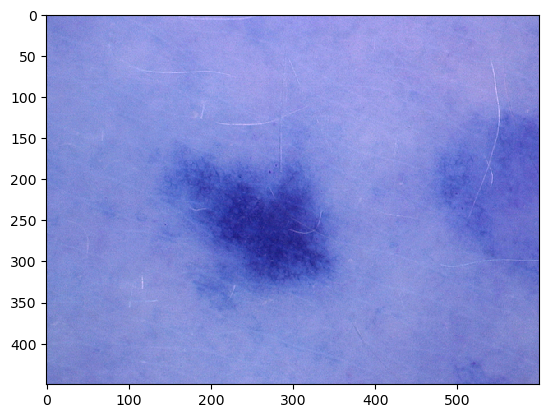

(256, 256, 3)
1/1 [==============================] - 0s 17ms/step
True Label:             image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
126  ISIC_0034454  0.0  1.0  0.0    0.0  0.0  0.0   0.0
Predicted Label: [1]


TypeError: Invalid shape (1,) for image data

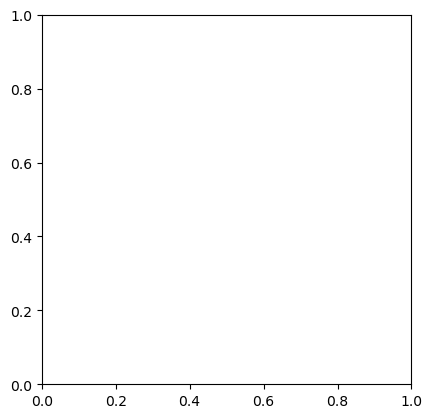

In [10]:
pred_folder = "validation/ISIC2018_Task3_Validation_Input/"
pred_image = "ISIC_0034454"
labels_path = "validation_ground_truth/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv"
classification.load_weights("final_class.h5")

pred_label_df = pd.read_csv(labels_path)
pred_label = pred_label_df.loc[pred_label_df['image']==pred_image]


test_image = np.array(cv2.imread(os.path.join(pred_folder, pred_image) + ".jpg"))

plt.imshow(test_image, interpolation='nearest')
plt.show()

pred_image = cv2.resize(test_image, (256,256))
print(pred_image.shape)
#pred_image = tf.stack(pred_image)
pred = classification.predict(pred_image[None,])
#pred = np.argmax(classification.predict(pred_image[None,]), axis=-1)

#img = mpimg.imread('your_image.png')
#imgplot = plt.imshow(img)
#plt.show()
print(f"True Label: {pred_label}")
print(f"Predicted Label: {pred}")

plt.imshow(pred, interpolation='nearest')
plt.show() 


In [38]:
model.save_weights('model.h5')

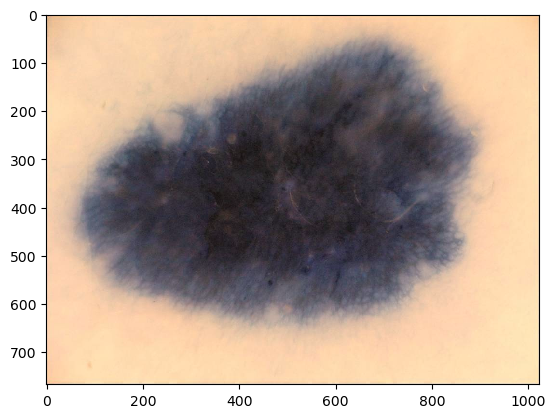

(256, 256, 3)


ValueError: in user code:

    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/danny/anaconda3/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "unet" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(1, 256, 3)


In [68]:
pred_folder = "seg/ISIC2018_Task1-2_Training_Input/ISIC2018_Task1-2_Training_Input/"

pred_image = np.array(cv2.imread(os.path.join(pred_folder,"ISIC_0000000.jpg")))

plt.imshow(pred_image, interpolation='nearest')
plt.show()

pred_image = cv2.resize(pred_image, (256,256))
pred_image=pred_image//255
print(pred_image.shape)
#pred_image = tf.stack(pred_image)

pred = model.predict(pred_image, batch_size=1)

#img = mpimg.imread('your_image.png')
#imgplot = plt.imshow(img)
#plt.show()
plt.imshow(pred, interpolation='nearest')
plt.show() 

In [ ]:
#validation gt
#valid_gt_X = load_folder_imgs("seg/ISIC2018_Task1-2_Validation_Input")
#valid_gt_y = load_folder_imgs("seg/ISIC2018_Task1_Validation_GroundTruth")
model.evaluate(valid_gt, verbose=0, batch_size=32, steps=2)


NameError: name 'valid_gt' is not defined

In [ ]:
#train classification w/ U_net on full images
U_Net.trainable = False
classification.trainable = True

model.fit(x=train_ds_X, y=train_ds_y, epochs=10, batch_size=train_ds.length, callbacks=callback_list, verbose=2)

In [ ]:
#validation full

model.predict(valid_ds, verbose=0, batch_size=128, steps=2)


(256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
(128, 128, 3)
<class 'numpy.ndarray'>


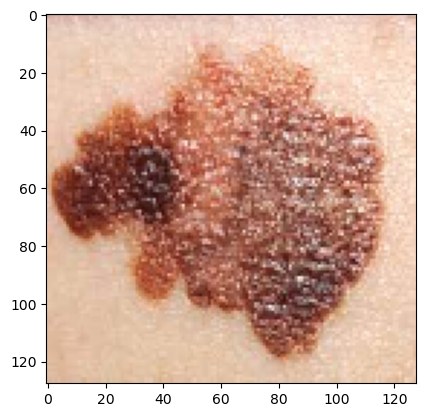

In [ ]:
img = Image.open("melanoma.jpg")
img = img.resize((256,256))
plt.imshow(img)
img = np.array(img)


test = Sequential([
    layers.InputLayer(shape=(256,256,3)),
    layers.MaxPooling2D(pool_size=(2,2))
])

test.compile('adam', 'binary_cross_entropy')
print(img.shape)
img2 = np.expand_dims(img, 0)

res = test.predict(img2, steps=1)
res.shape
res2 = res[0,:,:,:]
print(res2.shape)
plt.imshow((res2).astype(np.uint8)) # *255 to negative??
#plt.imshow(img)
print(type(res2[0][0]))

In [ ]:
#compilation code here
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=["binary_accuracy"]) # we can actually use metrics without matplotlib!!!! woww!!! i think

callback_list = [tf.keras.callbacks.EarlyStopping(patience=2)] #can adjust to improve accuracy

#early stopping used to prevent overfitting

model.fit(train_ds, epochs=10, callbacks=callback_list)